# Titanic Random Forest


For my first Kaggle competition entry I decided to follow through on the .
Using the two kernels below as guidance.
- https://www.kaggle.com/goldens/classification-81-3-with-simple-model-nested-cv
- https://www.kaggle.com/yassineghouzam/titanic-top-4-with-ensemble-modeling

## Imports

In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

## Load data into pandas dataframes

In [74]:
training_filename = 'train.csv'
test_filename = 'test.csv'

In [118]:
df_raw_train = pd.read_csv('train.csv')
df_raw_test = pd.read_csv('test.csv')

## Joining test and train
Joining our test and train data has a number of advantages.
1. Allows for processing both our data sets in the same manner.
2. Grants insight across the whole range of data we are working with.
3. Ensures that we maintain the same number and type of features.

The major disadvantage here is that we will be introducing a selection of the data which does not contain Survival values. While we don't really need to worry about this too much, it is important to consider if we want to make any decisions regarding splitting up categories based on Survival probabilities. 

In [119]:
train_len = len(df_raw_train)
df_raw = pd.concat(objs=[df_raw_train, df_raw_test], axis=0, sort=False).reset_index(drop=True)

## Inspection
Start by taking a look at the data.

In [77]:
df_raw.dtypes.sort_values()

PassengerId      int64
Pclass           int64
SibSp            int64
Parch            int64
Survived       float64
Age            float64
Fare           float64
Name            object
Sex             object
Ticket          object
Cabin           object
Embarked        object
dtype: object

In [78]:
df_raw.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

In [79]:
df_raw.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


So there is work to be done in categorical conversion and in filling in null values.

We finally also take a quick look at the format of the data itself, in order to make some first guesses at possible conversions and feature engineering.

### Fill in missing values
For completeness, we fill all NaN values with `np.nan`

In [82]:
df = df_raw.fillna(np.nan).copy()

## Data Analysis
Before we begin any feature engineering, we begin by doing some basic analysis of the data as handed to us.

### Numerical Types

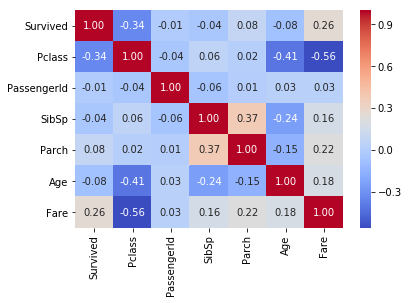

In [84]:
# PassengerId      int64
# Pclass           int64
# SibSp            int64
# Parch            int64
# Survived       float64
# Age            float64
# Fare           float64

g = sns.heatmap(df[["Survived","Pclass","PassengerId","SibSp","Parch","Age","Fare"]].corr(),annot=True, fmt = ".2f", cmap = "coolwarm")

At first it appears that "Fare" and "Pclass" are good places to start. This should not rule out investigation of the other features.

#### Fare
As a good first example, we will simply examine the relationship between this feature and the goal predictee.

There was a single NaN value, we'll simply replace it with the mean. We could have gone through the process of working out some intrinsic average based on similar local features, but we want to avoid "overfitting" our data to what we expect, and all this work to produce a single value would be a break of this attitude.

In [85]:
df.Fare = df.Fare.fillna(df.Fare.mean())

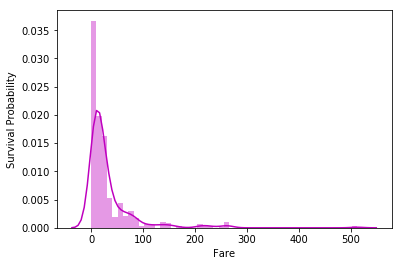

In [86]:
g = sns.distplot(df["Fare"], color="m")
g.set(ylabel="Survival Probability");


There is a fairly extreme skew to this data, we can assist our classifier by reducing this skew.

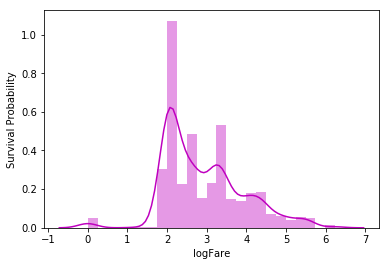

In [87]:
df["logFare"] = df.Fare.apply(lambda x: np.log(x) if x > 0 else 0)

g = sns.distplot(df["logFare"], color="m")
g.set(ylabel="Survival Probability");

#### Pclass
Nothing to do here, the data is already well categorised and there are no missing values. Good old 1900s British class systems, of course it's sorted.

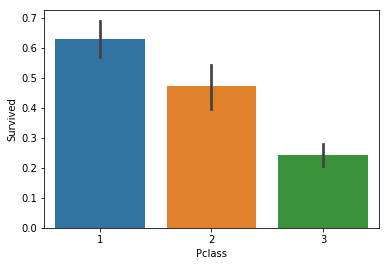

In [89]:
g = sns.barplot(x="Pclass", y="Survived", data=df)

#### SibSp and Parch
Inspired by the aforementioned Kernels to adapt this into a singular feature which would simply show the number of relatives an individual has onboard.

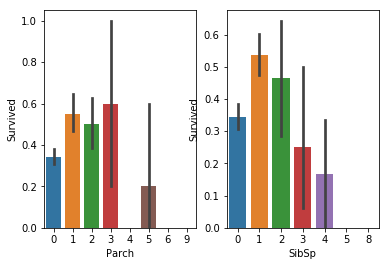

In [90]:
plt.figure()
plt.subplot(1,2,1)
sns.barplot('Parch', 'Survived',data=df)
plt.subplot(1,2,2)
sns.barplot('SibSp','Survived',data=df);

In [91]:
df["FamilySize"] = df.Parch + df.SibSp 

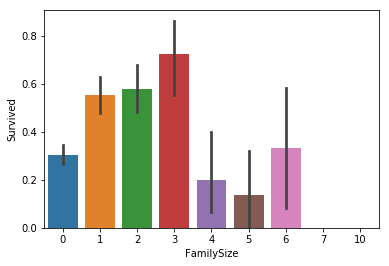

In [92]:
sns.barplot('FamilySize', 'Survived', data=df);

From this plot it would be reasonable to conclude that there are three particular groups: single, small families, and large families.

In [93]:
def categorise_family_size(family_size):
    mapping = {
        'Single' : 0,
        'Small' : 1,
        'Large' : 2
    }
    if family_size == 0:
        return mapping['Single']
    elif family_size > 0 and family_size < 4:
        return mapping['Small']
    elif family_size >= 4:
        return mapping['Large']

In [95]:
df.FamilySize = df.FamilySize.apply(categorise_family_size)

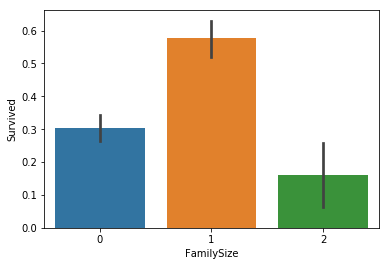

In [96]:
sns.barplot('FamilySize', 'Survived', data=df);

#### Age
Our final numerical metric to examine is age. If we review our "isnull" prompt we can see that this is a feature that contains a significant number of missing values. My first thought was to average this over class, but then I saw an implementation of tackling it by averaging ages by title and gender, then assigning it to each individual that way. So in order to tackle age properly we first need to process that. Age will be revisited at the end of this section.

### Categorical Data

#### Names
An obvious contender for making the "Name" feature usable is to extract the titles from the names, as these are the only generalisable component. 


In [97]:
def get_unique_titles(names):
    unique_titles = []
    for name in names:
        title = get_title_from_name(name)
        if title not in unique_titles:
            unique_titles.append(title)
    return unique_titles

def get_title_from_name(name):
    return name.split(',')[1].split('.')[0].strip()

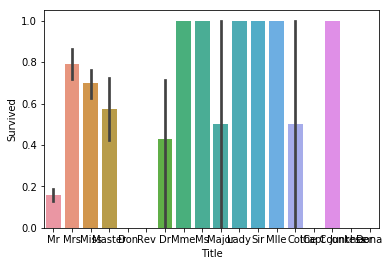

In [103]:
df['Title'] = df_raw.Name.apply(get_title_from_name)
sns.barplot('Title', 'Survived', data=df);

In [105]:
df.Title.value_counts()

Mr              757
Miss            260
Mrs             197
Master           61
Dr                8
Rev               8
Col               4
Ms                2
Major             2
Mlle              2
Lady              1
Jonkheer          1
Sir               1
Dona              1
Mme               1
the Countess      1
Capt              1
Don               1
Name: Title, dtype: int64

In [106]:
all_names = df.Name
titles = get_unique_titles(all_names)

title_mapping = {
    'Mr' : 2,
    'Mrs' : 1,
    'Miss' : 1,
    'Master' : 0,
    'Don' : 3,
    'Rev' : 3,
    'Dr' : 3,
    'Mme' : 1,
    'Ms' : 1,
    'Major' : 3,
    'Lady' : 3,
    'Sir' : 3,
    'Mlle' : 3,
    'Col' : 3,
    'Capt' : 3,
    'the Countess' : 3,
    'Jonkheer' : 3,
    'Dona' : 3
}

df['Title'] = df.Name.apply(get_title_from_name)
df.Title = df.Title.apply(lambda x: title_mapping[x])

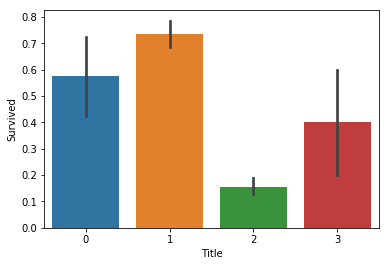

In [107]:
sns.barplot('Title', 'Survived', data=df);

#### Cabin
The Cabin data looks quite messy, as presently there are are an enormous collection of unique categorical values, which is not good for RFs.

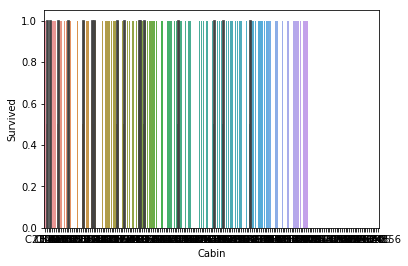

In [120]:
sns.barplot('Cabin', 'Survived', data=df)

In [121]:
df_raw.Cabin.value_counts().head()

C23 C25 C27        6
G6                 5
B57 B59 B63 B66    5
C22 C26            4
F4                 4
Name: Cabin, dtype: int64

Without looking at the room plan of the Titanic, a first reasonable guess would be to strip the room down to the cabin's first character. There were also a large collection of NaNs in this feature, possibly people without cabins (on almost a week long voyage, oof.), and we'll fill this in as its own category.

In [122]:
def replace_cabins_with_level(cabin):
    if pd.isnull(cabin):
        return 'X'
    else:
        return 'Y'

In [123]:
df.Cabin = df_raw.Cabin.apply(replace_cabins_with_level)

In [125]:
df.Cabin.value_counts()

X    1014
Y     295
Name: Cabin, dtype: int64

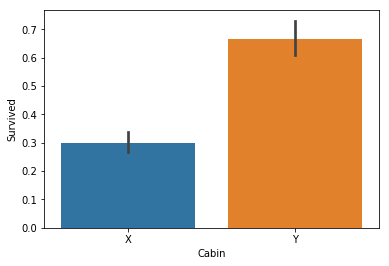

In [128]:
sns.barplot(x="Cabin", y="Survived", data=df);

Immediately we see that the more important principle appears to be whether the individual actually had a cabin at all, not really where it was. But this will do for now.

#### Embarked
The location of embarkment. Again, a category that doesn't require much manipulation. It does have a couple of NaNs that need to be filled in however.

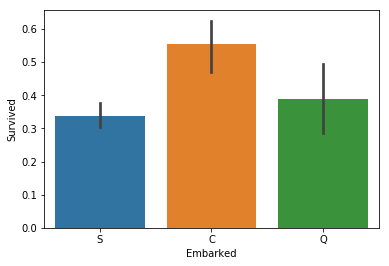

In [130]:
g= sns.barplot(x="Embarked", y="Survived", data=df_raw)

In [131]:
def replace_embarked_null(embarked):
    if pd.isnull(embarked):
        return 'X'
    else:
        return embarked

In [132]:
df.Embarked = df_raw.Embarked.apply(replace_embarked_null)

#### Ticket
A more difficult one to handle. However it appears that every ticket comes with a unique final integer string. So we can immediately consider stripping this. On further investigation there seems to be a widely variant ticketing process. A first go to make some usable categories was discovered to be stripping away everything but the very first character in each ticket.

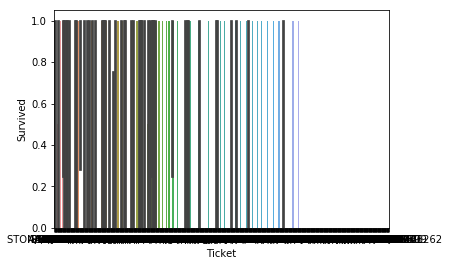

In [133]:
sns.barplot("Ticket", "Survived", data=df_raw)

In [134]:
df_raw.Ticket.head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

In [136]:
df_raw.Ticket.value_counts().head()

CA. 2343    11
1601         8
CA 2144      8
347082       7
3101295      7
Name: Ticket, dtype: int64

In [137]:
def process_tickets(ticket):
    if ticket.isdigit():
        return 'X'
    else:
        return ticket[0]

In [138]:
df["Ticketproc"] = df_raw.Ticket.apply(process_tickets)

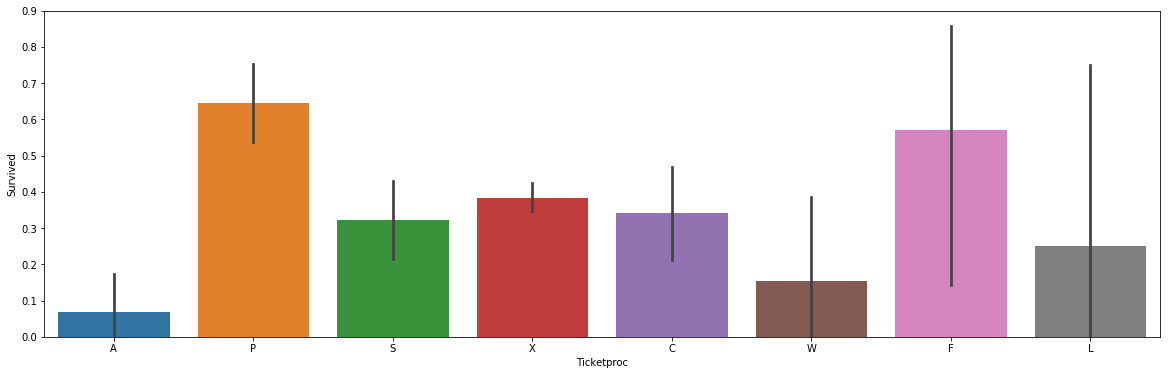

In [139]:
plt.figure(figsize=[20,6])
sns.barplot("Ticketproc", "Survived", data=df)

In [140]:
df.Ticketproc.value_counts()

X    957
S     98
P     98
C     77
A     42
W     19
F     13
L      5
Name: Ticketproc, dtype: int64

### Returning back to Age
For each title and gender in we want to find the mean age, excluding NaNs, and then replace all NaNs with that age.

In [142]:
df.groupby(['Title','Sex']).Age.mean()

Title  Sex   
0      male       5.482642
1      female    28.569607
2      male      32.252151
3      female    36.166667
       male      45.666667
Name: Age, dtype: float64

In [143]:
df_raw.Age.mean()

29.881137667304014

In [144]:
def replace_null_ages_with_mean(cols):
    age = cols[0]
    title = cols[1]
    sex = cols[2]
    if pd.isnull(age):
        if title == 0:
            return 5
        elif title == 1:
            return 29
        elif title == 2:
            return 32
        elif title == 3 and sex == 'female':
            return 36 
        elif title == 3 and sex == 'male':
            return 46
        else:
            return 30
    else:
        return age

In [145]:
df.Age = df[["Age", "Title", "Sex"]].apply(replace_null_ages_with_mean, axis=1)

## Reflect on changes

In [146]:
df.isnull().sum()

PassengerId      0
Survived       418
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin            0
Embarked         0
logFare          0
FamilySize       0
Title            0
Ticketproc       0
dtype: int64

In [147]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'logFare', 'FamilySize',
       'Title', 'Ticketproc'],
      dtype='object')

Dropping columns that we no longer need: "PassengerId", "Name", "SibSp", "Parch, "Ticket", "Fare",

In [148]:
df_final = df.drop(["PassengerId", "Name", "SibSp", "Parch", "Ticket", "Fare"], axis=1)

In [150]:
df_final = pd.get_dummies(df_final)

## Make ready for modelling

In [151]:
df_final.to_csv('df_final.csv', index=False)

In [152]:
df_train = df_final[:train_len]
df_test = df_final[train_len:]
test = df_test.drop("Survived", axis=1)

In [153]:
df_train.shape, df_test.shape

((891, 22), (418, 22))

In [154]:
x_train = df_train.drop("Survived", axis=1)
y_train = df_train["Survived"]

In [158]:
RF=RandomForestClassifier(n_estimators=100, max_depth=6, criterion='gini')
#PRF=[{'n_estimators':[10,100],'max_depth':[3,6,10],'criterion':['gini','entropy']}]
#GSRF=GridSearchCV(estimator=RF, param_grid=PRF, scoring='accuracy', cv=2)

In [159]:
scores_rf=cross_val_score(RF,x_train,y_train,scoring='accuracy', cv=5); scores_rf

array([0.84357542, 0.82681564, 0.83146067, 0.80898876, 0.85875706])

In [160]:
model = RF.fit(x_train, y_train)

In [161]:
pred=model.predict(test).astype(int)

output=pd.DataFrame({'PassengerId':df_raw_test['PassengerId'],'Survived':pred})

output.to_csv('submission.csv', index=False)

## Reading back

In [162]:
df = pd.read_csv('df_final.csv')

In [163]:
RF=RandomForestClassifier(n_estimators=100, max_depth=6, criterion='gini')
train_len = 891
train = df[:train_len]
test = df[train_len:]
test = test.drop("Survived", axis=1)
x_train = train.drop("Survived", axis=1)
y_train = train["Survived"]
model = RF.fit(x_train, y_train)

## Interpretation

In [164]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [165]:
fi = rf_feat_importance(model, x_train); fi[:10]

,cols,imp
4,Title,0.209057
5,Sex_female,0.182237
6,Sex_male,0.138691
2,logFare,0.103506
0,Pclass,0.090168
1,Age,0.076381
3,FamilySize,0.065224
7,Cabin_X,0.035904
8,Cabin_Y,0.035103
11,Embarked_S,0.011491


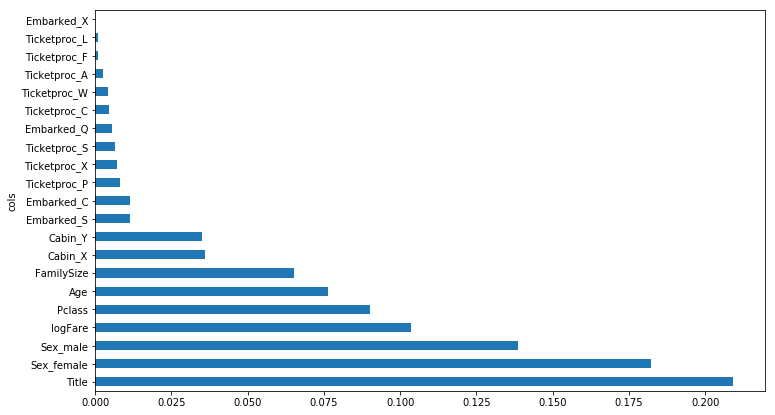

In [167]:
fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

In [168]:
to_keep = fi[fi.imp>0.025].cols; len(to_keep)
x_train_keep = x_train[to_keep].copy()
test_keep = test[to_keep].copy()

In [185]:
RF=RandomForestClassifier(n_estimators=100, max_depth=6, criterion='gini')
model = RF.fit(x_train_keep, y_train)

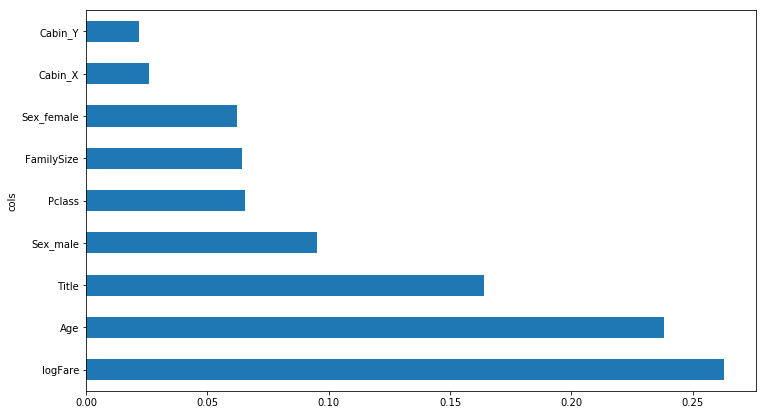

In [184]:
fi = rf_feat_importance(model, x_train_keep)
fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

In [182]:
scores_rf=cross_val_score(RF,x_train_keep,y_train,scoring='accuracy', cv=5); scores_rf

array([0.84357542, 0.82122905, 0.84269663, 0.80898876, 0.84745763])

Let's make a submission using this reduced complexity model to start with, and see how it performs.

In [179]:
pred=model.predict(test_keep).astype(int)

output=pd.DataFrame({'PassengerId':df_raw_test['PassengerId'],'Survived':pred})

output.to_csv('submission.csv', index=False)

Our score for this model, with under a third of the features initially used, scored very similarly. 

We might want to consider some further feature analysis on "Title" and "FamilySize"